In [1]:
#from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
import time
import datetime
import xarray as xr
#from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
####################you will need to change some paths here!#####################
#list of input files
dir_in='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
dir_figs='f:/data/tc_wakes/database/coldwake_images/'
#################################################################################
#from math import cos, radians
import geopy.distance
from math import sin, pi
from scipy import interpolate



In [2]:
def get_dist_grid(lat_point,lon_point,lat_list,lon_list):
    # adapted from chelle's routine
    #this routine takes a point and finds distance to all points in a grid of lat and lon
    dist_grid = np.empty((len(lat_list)))    
    coords_1 = (lat_point, lon_point)  
    for i in range(len(lat_list)):
        coords_2 = (lat_list[i], lon_list[i])  
        arclen_temp = geopy.distance.geodesic(coords_1, coords_2).km  #distance in km   
        #print(arclen_temp)
        dist_grid[i]=arclen_temp
    return dist_grid


def find_storm_beginend(pdt,dt,dttime,sif,storm,storm_date): # a point in sif
    # find begining and end of storm influence
    thwnd=5 # threshold of wind speed to consider significant storm
    thdist=600 # threshold of distance strom traveled between two day to consider it close
    
    # calculate speed for all times of pdt
    spd=np.sqrt(dt[pdt,:,1]*dt[pdt,:,1]+dt[pdt,:,2]*dt[pdt,:,2])
    
    # calculate distance from point pdt to each storm track point 
    nd=get_dist_grid(sif['lat'][pdt],sif['lon'][pdt],storm.lat.values[0],storm.lon.values[0])
    
    # find min distance from storm to point and time
    clod=min(nd) # closest distance to storm
    a=np.where(nd==clod)
    b=a[0][0] # index of closest distance on storm track
    ndi=np.abs(dttime - storm_date[b]).argmin() # find index of time on data where storm is closest
    
    # choose closest as first day of strom to begin
    begs=ndi # index on data for closest point to storm
    tb=b # Storm time index of closest
    # look for the days before to see if storm arrived earlier (strong winds and close storm)
    
    # find distance to storm at day before  
    if tb>2: # only days when storm closest distance is later than the first few storm points
        if spd[begs]<=thwnd: # wind speed of closest is below threshold end routine
            ok=0 # end search for beginning and do not search for end
            ends=begs
        else: # look for begining day before 
            ok=0
            while ok==0:
                if tb>2: # there is a previous storm day
                    if spd[begs-1]<=thwnd: # if previous wind is below threshold end routine
                        # the day begs is the real begining, but we have found the begining
                        ok=1 
                    else: # check distance 
                        # calculate distance to storm at begs-1
                        # fist calculate storm time closest to begs-1
                        #tb=np.abs(np.array(storm_date)-dttime[begs-1]).argmin() 
                        #if np.logical_and(b-tb>3,tb>2): # making sure that the begs-1 is still a storm day (and a real day before the closest)
                        if tb-4>0:
                            dts=nd[tb-4] # distance to storm at begs-1 time
                            if dts>=thdist: # if storm was too far the day before, then wind is probably not due to the storm
                                ok=1 # leave begs as the begining of storm
                            else: # if the storm was close the day before, keep lookin
                                begs=begs-1
                                tb=tb-4
                        else: # no room to go back
                            ok=1
                else: # there is no prveious strom date
                    ok=1
                    
                
    else: # point is to close to the begining of the strom - begin assumed the closest day
        ok=1 # look for end of storm
    
    if ok==1: # check for the end of the storm 
        
        # end of event when storm ends
        endstorm=np.abs(dttime - storm_date[len(storm_date)-1]).argmin()
        ok=0
        ends=begs+1 # end of strom influence
        while np.logical_and(ok==0,ends<=endstorm):
            if nd[ends]>thdist: # Storm too far away
                ok=1
            else:
                if spd[ends]<thwnd:
                    ok=1
                else:
                    ends=ends+1
        
    #print(nd[tb],spd[begs])
 
    return begs, ends, clod


def cold_wake(pn,dt,nidx,nfdx):
    # find and quantify cold wake
    # pass point, day (index) of storm arrival, and end of wind forcing (storm)
    # returns: dcwi0 (beg of coldwake),lencw (lenght), sst0 (base temp), mxdT (max cooling), mxdTi (day of max cool, relative to cold wake beg)
    # returns also: mld (mix layer depth at begining of storm)
    
    # within the 2 next days (realistic?)
    # needs fixing to consider increases in wind
    cow=0 # is there a cold wake? 0 = no
    dcwi0=np.nan
    lencw=nfdx-nidx
    mxdT=np.nan
    try: 
        sst0=np.mean(dt[pn,nidx-1-4:nidx-1,0])
    except:
        sst0=np.mean(dt[pn,:nidx-1,0])

    
    # test if lenght of wind event is longer than 0... if not, no coldwake to calculate
    if nfdx-nidx>0:
        # find if there is really a cold wake. look for 5 days
        of=0
        ok=0
        while np.logical_and(ok==0, of<6):
            # is there a change in temp before begining of storm and previous day
            ct=dt[pn,nidx+of,0]-sst0 # nidx first day of "cooling" (the day the storm begins)
            # is there a cold wake?
            if ct > 0: # no decrease in temp, go for the next day, recalculate SST0
                of=of+1
                try: 
                    sst0=np.mean(dt[pn,nidx+of-1-4:nidx+of-1,0])
                except:
                    sst0=np.mean(dt[pn,:nidx+of-1,0])
            else:  # decrease, so start counting... but only if change is low
                #print('Cold wake') # cooling start the day after the storm begins (nidx+1)
                cow=1
                ok=1

        # if coldwake
        if cow==1:
            #print(of)

            # for the next days, calculate (#days), cumulative SSTa (from SST0), and max SSTa until the diff is < ?? 0.1
            dcwi0=nidx+of # first day of cold wake (for now same as arriving o f storm)
            dcwi=nidx+of # index to count days of cold wake
            lencw=1 # length of cold wake
#            print('1:',pn,dcwi,dt[pn,dcwi,0])
            mxdT=dt[pn,dcwi,0]-sst0 # max change in temp during the wake

            # first day doesn't get evaluated (already a change) 
            dcwi=dcwi+1
            ok=0
            mxok=0
            while np.logical_and(ok==0,lencw<15):  
                # "anomaly stil larger than 0.1C, or the cw last less than 10days)
#                print(dt.dims)
#                print(dt.shape)
#                print(pn)
#                print(dcwi)
#                print(sst0)
#                print(sst0.values)
#                print(dt[pn,dcwi,0])
                if dt[pn,dcwi,0]<(sst0.values-0.1):
#                    print('here')
                    # if temp keeps decreasing check for max change
                    if np.logical_and(dt[pn,dcwi,0]<dt[pn,dcwi-1,0],mxok==0):
                        if dt[pn,dcwi,0]-sst0<mxdT: # is today colder than the min SST from before?
                            mxdT=dt[pn,dcwi,0]-sst0 # min SST 
                        else:
                            mxok=1 # look for further for mx change
                    dcwi=dcwi+1
                    lencw=lencw+1
                else: # end of cold wake
                    ok=1
                    # length remain the same
        
    return cow,dcwi0,lencw,sst0, mxdT


In [3]:
def entire_storm_wake(iyr,inum_storm):
    stnyr = str(iyr)
    stn = str(inum_storm).zfill(3)
    fn2=dir_in+stnyr+'/'+stn+'annual_storm_info.nc'
    storm=xr.open_dataset(fn2)
    storm.close()
    # transform storm time to comparable time to data
    date_1858 = datetime.datetime(1858,11,17) # start date is 11/17/1958
    storm_date=[0]*len(storm.time.values[0]) 
    for i in range(len(storm.time.values[0])):
        storm_date[i]=date_1858+datetime.timedelta(days=float(storm.time.values[0][i]))  
    # transform storm lon to -180:180
    storm['lon'] = (storm['lon'] + 180) % 360 - 180
#CG    storm.lon[0]=[i-360 for i in storm.lon[0] if i>=180]
    fn=dir_out +stnyr+'/'+stn+'_combined_data.nc'
    dtd=xr.open_dataset(fn)
    dtd.close()
    #print(dt)
    #nmask=dt.storm_mask.where(dt.storm_mask<0)*-1
    nmask=dtd.dist_from_storm_km.where(dtd.dist_from_storm_km<600)
    #we also want the land mask
    nmask=nmask*0+1
    nmask=nmask*dtd.mask[0,:,:]
    # for each point (of data within the storm mask) get data into two structures: sif (all points), adfs (array)
    tp=0
    rw=[] # extra info array
    ar=np.full([50000,len(dtd.time),4],np.nan)
    for i in range(len(dtd.lat.values)):
        for j in range(len(dtd.lon.values)):
            if not np.isnan(nmask[i,j]):
                #print(i,j)
                #plt.plot(dt.lon[j],dt.lat[i],'b.-')

                # lat lon for each point in the mask
                tla=dtd.lat[i].values
                tlo=dtd.lon[j].values
                di=dtd.dist_from_storm_km[i,j].values
                # timeseries data (3d: point, t, [sst, u, v])
                # all time for data series
                ar[tp,:,0]=dtd.analysed_sst[:,i,j].values-273.15
                ar[tp,:,1]=dtd.uwnd[:,i,j].values
                ar[tp,:,2]=dtd.vwnd[:,i,j].values
                ar[tp,:,3]=dtd.dbss_obml[:,i,j].values # maybe redo for previous month

                rw.append([tla,tlo,di])
                tp=tp+1

    #print(tp, len(rw))
    tp=tp-1 # last index
    # convert info to dataframe and save
    cols=['lat','lon','dist_km']
    sif=pd.DataFrame(rw,columns=cols)
    #sif.to_csv('../data/storm_sum_data/info_locdist_'+stnyr+'.csv')

    # convert data to xarray
    ar=np.delete(ar,range(tp+1,50000),axis=0)
    dt=xr.DataArray(ar,coords=[range(tp+1),dtd.time,['SST','uwnd','vwnd','mld']],dims=['location','time','var']) 
    #adfs.to_netcdf('../data/storm_sum_data/stormdatamask_'+stnyr+'.nc')
    dttime=pd.to_datetime(dt.time.values) # datatime array
    # calculate cold wake and create mask
    plat=[]
    plon=[]
    pxdT=[] # max cooling
    psst0=[] # initial (base) temperature

    for pn in range(len(sif)):
        # calculate wind speed
        spd=np.sqrt(dt[pn,:,1]*dt[pn,:,1]+dt[pn,:,2]*dt[pn,:,2])
        # find actual arrival of storm date and wind at the time
        tw0,twf, clod=find_storm_beginend(pn,dt,dttime,sif,storm,storm_date)
        w0=spd[tw0]

        ## closest latitude in storm to point
        clolat=np.abs(storm['lat'][0].values - sif['lat'][pn]).argmin()
        # also get rid of points to close to the begining of the storm (8 points ~ 2 days)
        if (storm.lat[0,0].data>0) and (np.logical_or(storm['lon'][0].values[clolat]-sif['lon'][pn]>1,clolat<9)): ## !!! review this for southern hemisphere
            # no cold wake if more than 1 degree to the left of the storm 
            cow=0
        elif (storm.lat[0,0].data<0) and (np.logical_or(storm['lon'][0].values[clolat]-sif['lon'][pn]>1,clolat<9)): ## !!! review this for southern hemisphere
            # no cold wake if more than 1 degree to the left of the storm 
            cow=0
        else:
            # is there a cold wake? and quantify
            cow, tcw0, lcw, sst0, xdT = cold_wake(pn,dt,tw0,twf)    

        if cow==1:
            if np.logical_and(xdT<=-1,lcw>5): # threshold for cold wake
                pxdT.append(xdT) # max cooling
                psst0.append(sst0)

                # from storm info file
                plat.append(sif['lat'][pn])
                plon.append(sif['lon'][pn])
    # create a mask
    coldwake=np.full((len(dtd.lat.values),len(dtd.lon.values)),np.nan)
    coldwake_mask=np.full((len(dtd.lat.values),len(dtd.lon.values)),0.0)
    prestorm_sst=np.full((len(dtd.lat.values),len(dtd.lon.values)),nan)
    for i in range(len(plat)):
        a=np.where(dtd.lat.values==plat[i])
        b=np.where(dtd.lon.values==plon[i])
        coldwake[a[0][0],b[0][0]]=pxdT[i]
        coldwake_mask[a[0][0],b[0][0]]=1
        prestorm_sst[a[0][0],b[0][0]]=psst0[i]
    return dtd,storm,coldwake,coldwake_mask,prestorm_sst


In [ ]:

for root, dirs, files in os.walk(dir_in, topdown=False):
    if root[len(dir_in):len(dir_in)+1]=='.':
        continue
    for name in files:
        if not name.endswith('.nc'):
            continue
        fname_in=os.path.join(root, name)
        print(fname_in[36:39],fname_in[31:35])
        inum_storm=int(fname_in[36:39])
        iyr_storm=int(fname_in[31:35])

        print('processing:',iyr_storm,inum_storm)
        dtd,storm,coldwake,coldwake_mask,prestorm_sst = entire_storm_wake(iyr_storm,inum_storm)
        print('make figure')
        cm=plt.cm.get_cmap('seismic')
        plt.figure(figsize=(14,4))
        x,y=np.meshgrid(dtd.lon,dtd.lat)
        plt.subplot(131)
        plt.scatter(x,y,c=coldwake,s=15, alpha=0.8, cmap=cm,vmin=-3,vmax=3)
        cb=plt.colorbar()
        cb.set_label('Max Cooling')
        plt.xlabel('Lon')
        plt.ylabel('Lat')
        plt.scatter(storm.lon.values,storm.lat.values,c='k',s=20, marker='*')

        cm=plt.cm.get_cmap('seismic')
        plt.subplot(132)
        plt.scatter(x,y,c=coldwake_mask,s=15, alpha=0.8, cmap=cm)
        cb=plt.colorbar()
        cb.set_label('Mask')
        plt.xlabel('Lon')
        plt.ylabel('Lat')
        plt.scatter(storm.lon.values,storm.lat.values,c='k',s=20, marker='*')

        cm=plt.cm.get_cmap('seismic')
        plt.subplot(133)
        plt.pcolormesh(dtd.lon,dtd.lat,(dtd.analysed_sst[10,:,:]-dtd.analysed_sst[0,:,:]),vmin=-2,vmax=2,cmap='seismic')
        plt.plot(storm.lon[0,:],storm.lat[0,:],'k')
        cb=plt.colorbar()
        cb.set_label('Mask')
        plt.xlabel('Lon')
        plt.ylabel('Lat')
        plt.scatter(storm.lon.values,storm.lat.values,c='k',s=20, marker='*')
        fname = dir_figs+str(iyr_storm)+str(inum_storm)+'_coldwake.png'
        plt.savefig(fname, dpi=100)


In [ ]:

iyr,inum_storm = 2002,7
dtd,storm,coldwake,coldwake_mask = entire_storm_wake(iyr,inum_storm)

cm=plt.cm.get_cmap('seismic')
plt.figure(figsize=(14,4))
x,y=np.meshgrid(dtd.lon,dtd.lat)
plt.subplot(131)
plt.pcolormesh(x,y,c=coldwake,s=15, alpha=0.8, cmap=cm,vmin=-3,vmax=3)
cb=plt.colorbar()
cb.set_label('Max Cooling')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.scatter(storm.lon.values,storm.lat.values,c='k',s=20, marker='*')

cm=plt.cm.get_cmap('seismic')
plt.subplot(132)
plt.scatter(x,y,c=coldwake_mask,s=15, alpha=0.8, cmap=cm)
cb=plt.colorbar()
cb.set_label('Mask')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.scatter(storm.lon.values,storm.lat.values,c='k',s=20, marker='*')

cm=plt.cm.get_cmap('seismic')
plt.subplot(133)
plt.pcolormesh(dtd.lon,dtd.lat,(dtd.analysed_sst[10,:,:]-dtd.analysed_sst[0,:,:]),vmin=-2,vmax=2,cmap='seismic')
plt.plot(storm.lon[0,:],storm.lat[0,:],'k')
cb=plt.colorbar()
cb.set_label('Mask')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.scatter(storm.lon.values,storm.lat.values,c='k',s=20, marker='*')
fname = dir_figs+str(iyr)+str(inum_storm)+'_coldwake.png'
plt.savefig(fname, dpi=100)


In [ ]:
cm=plt.cm.get_cmap('seismic')
plt.figure(figsize=(14,4))
x,y=np.meshgrid(dtd.lon,dtd.lat)
plt.subplot(131)
plt.pcolormesh(x,y,coldwake, cmap=cm,vmin=-3,vmax=3)
cb=plt.colorbar()
cb.set_label('Max Cooling')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.scatter(storm.lon.values,storm.lat.values,c='k',s=20, marker='*')

cm=plt.cm.get_cmap('seismic')
plt.subplot(132)
plt.scatter(x,y,c=coldwake_mask,s=15, alpha=0.8, cmap=cm)
cb=plt.colorbar()
cb.set_label('Mask')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.scatter(storm.lon.values,storm.lat.values,c='k',s=20, marker='*')

cm=plt.cm.get_cmap('seismic')
plt.subplot(133)
plt.pcolormesh(dtd.lon,dtd.lat,(dtd.analysed_sst[15,:,:]-dtd.analysed_sst[0,:,:]),vmin=-2,vmax=2,cmap='seismic')
plt.plot(storm.lon[0,:],storm.lat[0,:],'k')
cb=plt.colorbar()
cb.set_label('Mask')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.scatter(storm.lon.values,storm.lat.values,c='k',s=20, marker='*')
fname = dir_figs+str(iyr)+str(inum_storm)+'_coldwake.png'
plt.savefig(fname, dpi=100)


In [ ]:
cm=plt.cm.get_cmap('seismic')
#plt.subplot(1)
plt.pcolormesh(dtd.lon,dtd.lat,(dtd.analysed_sst[15,:,:]-dtd.analysed_sst[0,:,:]),vmin=-2,vmax=2,cmap='seismic')
plt.plot(storm.lon[0,:],storm.lat[0,:],'y')
cb=plt.colorbar()
cb.set_label('Mask')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.scatter(storm.lon.values,storm.lat.values,c='k',s=20, marker='*')
plt.plot(dtd.lon[47],dtd.lat[62],'y*')

In [ ]:
dtd

In [ ]:
date_1858 = datetime.datetime(1858,11,17) # start date is 11/17/1958
#    for i in range(len(storm.time.values[0])):
#        storm_date[i]=date_1858+datetime.timedelta(days=float(storm.time.values[0][i]))  


In [ ]:
ilat,ilon = 62,47
print(coldwake_mask[ilat,ilon])
print(dtd.closest_storm_index[ilat,ilon].values)
print(date_1858+datetime.timedelta(days=float(dtd.closest_storm_time[ilat,ilon].values)))
plt.plot(dtd.time,2*(dtd.analysed_sst[0,ilat,ilon]-dtd.analysed_sst[:,ilat,ilon]))
plt.plot(dtd.time,np.sqrt(dtd.uwnd[:,ilat,ilon]**2+dtd.vwnd[:,ilat,ilon]**2))
plt.xticks(rotation=90)

In [ ]:
ilat,ilon = 55,45
print(coldwake_mask[ilat,ilon])
print(dtd.closest_storm_index[ilat,ilon].values)
print(date_1858+datetime.timedelta(days=float(dtd.closest_storm_time[ilat,ilon].values)))
plt.plot(dtd.time,2*(dtd.analysed_sst[0,ilat,ilon]-dtd.analysed_sst[:,ilat,ilon]))
plt.plot(dtd.time,np.sqrt(dtd.uwnd[:,ilat,ilon]**2+dtd.vwnd[:,ilat,ilon]**2))
plt.xticks(rotation=90)

In [ ]:
import numpy as np
import datetime 
iyr,inum_storm=2002,1
stnyr = str(iyr)
stn = str(inum_storm).zfill(3)
fn2=dir_in+stnyr+'/'+stn+'annual_storm_info.nc'
storm=xr.open_dataset(fn2)
#storm.drop('j2')
storm.close()
# transform storm time to comparable time to data
date_1858 = datetime.datetime(1858,11,17) # start date is 11/17/1958
storm_date=[0]*len(storm.time.values[0]) 
for i in range(len(storm.time.values[0])):
    storm_date[i]=date_1858+datetime.timedelta(days=float(storm.time.values[0][i]))  
# transform storm lon to -180:180
#storm['lon'] = (storm['lon'] + 180) % 360 - 180
#print(pd.to_datetime(storm.time[0,0]) - pd.datetime(1858,11,17))
print(storm.time[0,0])
print(datetime.timedelta(days=float(storm.time.values[0,0])))
#print((storm.time[0] - datetime.datetime(1858,11,17).days))
#print(storm.time)
#print(np.datetime64('1858-11-17'),np.timedelta64(1,'D'))
#print(np.datetime64('1858-11-17')/np.timedelta64(1,'D'))
#sdate=(storm.time[0,:].values)-np.datetime64('1858-11-17')/np.timedelta64(1,'D')
#sdate2=datetime.utcfromtimestamp(tem2)


In [ ]:
#print(np.timedelta64(52207, 'D')-np.datetime64('1858-11-17'))
print(np.datetime64('1858-11-17'))
print(np.timedelta64(storm.time[0,0].values,'D'))
x = np.timedelta64(storm.time[0,0].values*(24*60*60*1e-9), 'ns')
days = x.astype('timedelta64[D]')

In [77]:

inum_storm,iyr_storm = 9,2015
#read in data
stnyr = str(iyr_storm)
stn = str(inum_storm).zfill(3)
filename=dir_in+stnyr+'/'+stn+'annual_storm_info.nc'
storm=xr.open_dataset(filename)
storm.close()
# transform storm time to comparable time to data
date_1858 = datetime.datetime(1858,11,17) # start date is 11/17/1958
storm_date=[0]*len(storm.time.values[0]) 
for i in range(len(storm.time.values[0])):
    storm_date[i]=date_1858+datetime.timedelta(days=float(storm.time.values[0][i]))  
# transform storm lon to -180:180
storm['lon'] = (storm['lon'] + 180) % 360 - 180
#CG    storm.lon[0]=[i-360 for i in storm.lon[0] if i>=180]
filename=dir_out +stnyr+'/'+stn+'_combined_data.nc'
ds_data=xr.open_dataset(filename)
ds_data.close()

#mask data
tdim,xdim,ydim = len(ds_data.time),len(ds_data.lon),len(ds_data.lat)
#create dummy variable dist to make distance from storm into same array size as all others in ds_data
dist=ds_data.uwnd.copy(deep=True)
for i in range(0,tdim):
    dist[i,:,:]=ds_data.dist_from_storm_km
ds_data['dist_from_storm_km_array']=dist

#find max sst 5 days before storm location
#first create an array with the storm crossover time (from nearest point) as an array
sdate = np.empty([ydim,xdim], dtype=datetime.datetime)    
for i in range(0,xdim):
    for j in range(0,ydim):
        tem=date_1858+datetime.timedelta(days=float(ds_data.closest_storm_time[j,i])) 
        sdate[j,i]=np.datetime64(tem)
xsdate=xr.DataArray(sdate, coords={'lat': ds_data.lat.values, 'lon':ds_data.lon.values}, dims=('lat', 'lon'))        
#now use array of storm time to calculate prestorm sst
sst0 = ds_data.dist_from_storm_km.copy(deep=True)
for i in range(0,xdim):
    for j in range(0,ydim):
        #sst0[j,i] = ds_data.analysed_sst[:,j,i].interp(time=xsdate[j,i])
        sst0[j,i] = ds_data.analysed_sst[:,j,i].sel(time=slice(xsdate[j,i]-np.timedelta64(5,'D'),xsdate[j,i])).max()
ds_data['sst_prestorm']=sst0

#is storm in southern or northen hemisphere?  ihem = 0 north ihem = 1 south
ihemisphere = 0
if ds_data.lat.max()<0:
    ihemisphere=1
if (storm.lat.max()-storm.lat.min())<(storm.lon.max()-storm.lon.min()):
    #look at each longitude, go from minimum to 0 to find dist < 100km
    dsmin = ds_data.dist_from_storm_km_array.argmin(dim='lat', skipna=True)
    for ilon in range(0,xdim):
        if ihemisphere==1:
            for j in range(dsmin[0,ilon].data,0,-1):
                if ds_data.dist_from_storm_km_array[0,j,ilon]>100:  #only keep 100km on one side of storm
                    ds_data.mask[:,:j,ilon]=2
                    break
        else:
            for j in range(dsmin[0,ilon].data,ydim):
                if ds_data.dist_from_storm_km_array[0,j,ilon]>100:  #only keep 100km on one side of storm
                    ds_data.mask[:,j:,ilon]=2
                    break
else:
    #look at each longitude, go from minimum to 0 to find dist < 100km
    dsmin = ds_data.dist_from_storm_km_array.argmin(dim='lon', skipna=True)
    for ilat in range(0,ydim):
        if ihemisphere==0:
            for i in range(dsmin[0,ilat].data,0,-1):
                if ds_data.dist_from_storm_km_array[0,ilat,i]>100:  #only keep 100km on one side of storm
                    ds_data.mask[:,ilat,:i]=2
                    break
        else:
            for i in range(dsmin[0,ilat].data,xdim):
                if ds_data.dist_from_storm_km_array[0,ilat,i]>100:  #only keep 100km on one side of storm
                    ds_data.mask[:,ilat,i:]=2
                    break
#now mask storm by land and distance from storm
ds_masked = ds_data.where((np.round(ds_data.mask)==1) & (ds_data.dist_from_storm_km_array<600))
ds_masked['spd']=np.sqrt(ds_masked.uwnd**2+ds_masked.vwnd**2)
ds_data['spd']=np.sqrt(ds_data.uwnd**2+ds_data.vwnd**2)
ds_data['coldwake_sst']=ds_data.sst_prestorm-ds_data.analysed_sst
ds_masked['coldwake_sst']=ds_masked.sst_prestorm-ds_masked.analysed_sst



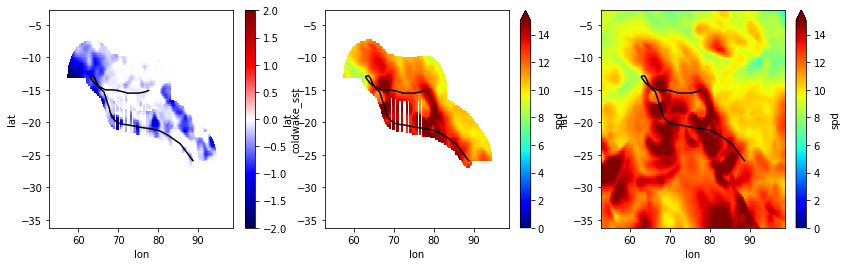

In [78]:
plt.figure(figsize=(14,4))
plt.subplot(131)
ds_masked.coldwake_sst.min(dim='time').plot(vmin=-2,vmax=2,cmap='seismic')
plt.plot(storm.lon[0,:],storm.lat[0,:],'k')
plt.subplot(132)
ds_masked.spd.max(dim='time').plot(vmin=0,vmax=15,cmap='jet')
plt.plot(storm.lon[0,:],storm.lat[0,:],'k')
plt.subplot(133)
ds_data.spd.max(dim='time').plot(vmin=0,vmax=15,cmap='jet')
plt.plot(storm.lon[0,:],storm.lat[0,:],'k')



In [82]:
def interpolate_storm_path(dsx):
    #after calculating the distance from the storm it became clear that the storm data is every 6 hours, no matter 
    #how much it may have moved.  So if the storm moved 300 km in 6 hr, when calculating the distance to the storm
    #there were points on the storm track that showed large distances because of the separation to the 6hrly storm points
    #this subroutine interpolates the storm path onto a higher spatial resolution
    #the new storm dataset is carefully put into an identical format with i2 and j2 as dims to match the old format
    ynew = []
    tnew = []
    xnew = []
    dsx['lon'] = (dsx.lon-180) % 360 - 180 #put -180 to 180
    for istep in range(1,dsx.lon.shape[1]):
        dif_lat = dsx.lat[0,istep]-dsx.lat[0,istep-1]
        dif_lon = dsx.lon[0,istep]-dsx.lon[0,istep-1]
        x,y,t = dsx.lon[0,istep-1:istep+1].values,dsx.lat[0,istep-1:istep+1].values,dsx.time[0,istep-1:istep+1].values
        if abs(dif_lat)>abs(dif_lon):
            isign = np.sign(dif_lat)
            if abs(dif_lat)>0.75:
                ynew1 = np.arange(y[0], y[-1], isign.data*0.75)
                f = interpolate.interp1d(y, x, assume_sorted=False)
                xnew1 = f(ynew1)
                f = interpolate.interp1d(y, t, assume_sorted=False)
                tnew1 = f(ynew1)
            else:
                xnew1,ynew1,tnew1 = x,y,t
            xnew,ynew,tnew = np.append(xnew,xnew1),np.append(ynew,ynew1),np.append(tnew,tnew1) 
        else:
            isign = np.sign(dif_lon)
            if abs(dif_lon)>0.75:
                iwrap_interp = 1
                if (x[0]<-90) & (x[-1]>90):
                    iwrap_interp = -1
                    x[0]=x[0]+360
                if (x[0]>90) & (x[-1]<-90):
                    iwrap_interp = -1
                    x[-1]=x[-1]+360
                xnew1 = np.arange(x[0], x[-1], iwrap_interp*isign.data*0.75)
                f = interpolate.interp1d(x, y, assume_sorted=False)
                ynew1 = f(xnew1)
                f = interpolate.interp1d(x, t, assume_sorted=False)
                tnew1 = f(xnew1)
                xnew1 = (xnew1 - 180) % 360 - 180 #put -180 to 180
            else:
                xnew1,ynew1,tnew1 = x,y,t
            xnew,ynew,tnew = np.append(xnew,xnew1),np.append(ynew,ynew1),np.append(tnew,tnew1) 
    i2,j2=xnew.shape[0],1
    tem = np.expand_dims(xnew, axis=0)
    xx = xr.DataArray(tem.T,dims=['i2','j2'])
    tem = np.expand_dims(ynew, axis=0)
    yy = xr.DataArray(tem.T,dims=['i2','j2'])
    tem = np.expand_dims(tnew, axis=0)
    tt = xr.DataArray(tem.T,dims=['i2','j2'])
    dsx_new = xr.Dataset({'lon':xx.T,'lat':yy.T,'time':tt.T})
    return dsx_new

def closest_dist(ds_in,ds_storm): 
# m.garcia-reyes 2.4.2019, edited c.gentemann 2.4.2019
# calculate distance closest storm point
# point given as tla,tlo.... storm is in the program
# initialize distances (in km)
    ds_storm['lon'] = (ds_storm.lon + 180) % 360 - 180
    dsx_input = ds_storm.copy(deep=True)
    ds_storm_new = interpolate_storm_path(dsx_input)       
    tdim,xdim,ydim=ds_storm_new.lat.shape[1], ds_in.analysed_sst[0,:,0].shape[0], ds_in.analysed_sst[0,0,:].shape[0]
    dx_save=np.zeros([tdim,xdim,ydim])
    dx_grid,dy_grid = np.meshgrid(ds_in.lon.values,ds_in.lat.values)
    lon_grid,lat_grid = np.meshgrid(ds_in.lon.values,ds_in.lat.values)
    min_dist_save = np.zeros([xdim,ydim])*np.nan
    min_index_save = np.zeros([xdim,ydim])*np.nan
    min_time_save = np.zeros([xdim,ydim])*np.nan
    position = np.zeros([xdim,ydim])*np.nan
    #for each location of the storm calculate the difference for all values in box
    for ipt in range(0,ds_storm_new.lat.shape[1]):  # all storm values
        dist_tem_grid = get_dist_grid(ds_storm_new.lat[0,ipt].values,ds_storm_new.lon[0,ipt].values,lat_grid,lon_grid)
        dx_save[ipt,:,:]=dist_tem_grid       
    #now go through each value in box and find minimum storm location/day
    for j in range(0,ds_in.lon.shape[0]):
        for i in range(0,ds_in.lat.shape[0]):
            imin = np.argmin(dx_save[:,i,j])
            min_dist_save[i,j]=dx_save[imin,i,j]
            min_index_save[i,j]=imin
            min_time_save[i,j]=ds_storm_new.time[0,imin]
            i1,i2=imin,imin+1
            if i2>ds_storm_new.lat.shape[1]:
                i1,i2=imin-1,imin
                lonx,laty=ds_in.lon[j],ds_in.lat[i]
#                sign((Bx - Ax) * (Y - Ay) - (By - Ay) * (X - Ax))
                position[i,j] = sign((storm.lon[0,i2] - storm.lon[0,i1]) * (laty - storm.lat[0,i1]) 
                                     - (storm.lat[0,i2] - storm.lat[0,i1]) * (lonX - storm.lon[0,i1]))
    #find left and right side of storm
    return min_dist_save,min_index_save,min_time_save,position

min_dist_save,min_index_save,min_time_save,position = closest_dist(ds_data,storm)


In [ ]:
ds_storm = storm.copy(deep=True)
ds_in = ds_data.copy(deep=True)

ds_storm['lon'] = (ds_storm.lon + 180) % 360 - 180
dsx_input = ds_storm.copy(deep=True)
ds_storm_new = interpolate_storm_path(dsx_input)       
tdim,xdim,ydim=ds_storm_new.lat.shape[1], ds_in.analysed_sst[0,:,0].shape[0], ds_in.analysed_sst[0,0,:].shape[0]
dx_save=np.zeros([tdim,xdim,ydim])
dx_grid,dy_grid = np.meshgrid(ds_in.lon.values,ds_in.lat.values)
lon_grid,lat_grid = np.meshgrid(ds_in.lon.values,ds_in.lat.values)
min_dist_save = np.zeros([xdim,ydim])*np.nan
min_index_save = np.zeros([xdim,ydim])*np.nan
min_time_save = np.zeros([xdim,ydim])*np.nan
position = np.zeros([xdim,ydim])*np.nan
#for each location of the storm calculate the difference for all values in box
for ipt in range(0,ds_storm_new.lat.shape[1]):  # all storm values
    dist_tem_grid = get_dist_grid(ds_storm_new.lat[0,ipt].values,ds_storm_new.lon[0,ipt].values,lat_grid,lon_grid)
    dx_save[ipt,:,:]=dist_tem_grid       
#now go through each value in box and find minimum storm location/day
for j in range(0,ds_in.lon.shape[0]):
    for i in range(0,ds_in.lat.shape[0]):
        imin = np.argmin(dx_save[:,i,j])
        min_dist_save[i,j]=dx_save[imin,i,j]
        min_index_save[i,j]=imin
        min_time_save[i,j]=ds_storm_new.time[0,imin]
        i1,i2=imin,imin+1
        if i2>ds_storm_new.lat.shape[1]:
            i1,i2=imin-1,imin
            lonx,laty=ds_in.lon[j],ds_in.lat[i]
#                sign((Bx - Ax) * (Y - Ay) - (By - Ay) * (X - Ax))
            position[i,j] = sign((storm.lon[0,i2] - storm.lon[0,i1]) * (laty - storm.lat[0,i1]) 
                                 - (storm.lat[0,i2] - storm.lat[0,i1]) * (lonX - storm.lon[0,i1]))


In [81]:

#################################################################################

inum_storm,iyr_storm = 9,2015
#read in data
stnyr = str(iyr_storm)
stn = str(inum_storm).zfill(3)
filename=dir_in+stnyr+'/'+stn+'annual_storm_info.nc'
storm=xr.open_dataset(filename)
storm.close()
# transform storm time to comparable time to data
date_1858 = datetime.datetime(1858,11,17) # start date is 11/17/1958
storm_date=[0]*len(storm.time.values[0]) 
for i in range(len(storm.time.values[0])):
    storm_date[i]=date_1858+datetime.timedelta(days=float(storm.time.values[0][i]))  
# transform storm lon to -180:180
storm['lon'] = (storm['lon'] + 180) % 360 - 180
#CG    storm.lon[0]=[i-360 for i in storm.lon[0] if i>=180]
filename=dir_out +stnyr+'/'+stn+'_combined_data.nc'
ds_data=xr.open_dataset(filename)
ds_data.close()
ds_data['spd']=np.sqrt(ds_data.uwnd**2+ds_data.vwnd**2)
plt.figure(figsize=(14,4))
plt.subplot(131)
(ds_data.analysed_sst_clim[0,:,:]-ds_data.analysed_sst.min(dim='time')).plot(vmin=-2,vmax=2,cmap='seismic')
plt.plot(storm.lon[0,:],storm.lat[0,:],'k')
plt.subplot(132)
ds_data.spd.max(dim='time').plot(vmin=0,vmax=15,cmap='jet')
plt.plot(storm.lon[0,:],storm.lat[0,:],'k')
plt.subplot(133)
#ds_data.spd.max(dim='time').plot(vmin=0,vmax=15,cmap='jet')
#plt.plot(storm.lon[0,:],storm.lat[0,:],'k')

#how to calculate if a point to the right or left of a line
#M(X,Y) query point
#A first point B second point along line
#for i in range(0,len(storm.time.values[0])-1):
#    position = sign((storm.lon[0,i+1] - storm.lon[0,i]) * (Y - storm.lat[0,i]) - (storm.lat[0,i+1] - storm.lat[0,i]) * (X - storm.lon[0,i]))



AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [29]:
xsdate
#ds_data
#sdate
#ds_data.interp(time=xsdate)

<xarray.DataArray (lat: 95, lon: 207)>
array([['2016-08-31T15:45:00.000345000', '2016-08-31T15:45:00.000345000',
        '2016-08-31T15:45:00.000345000', ..., '2016-08-24T06:00:00.000043000',
        '2016-08-24T06:00:00.000043000', '2016-08-24T06:00:00.000043000'],
       ['2016-08-31T15:45:00.000345000', '2016-08-31T15:45:00.000345000',
        '2016-08-31T15:45:00.000345000', ..., '2016-08-24T06:00:00.000043000',
        '2016-08-24T06:00:00.000043000', '2016-08-24T06:00:00.000043000'],
       ['2016-08-31T15:45:00.000345000', '2016-08-31T15:45:00.000345000',
        '2016-08-31T15:45:00.000345000', ..., '2016-08-24T06:00:00.000043000',
        '2016-08-24T06:00:00.000043000', '2016-08-24T06:00:00.000043000'],
       ...,
       ['2016-08-31T15:45:00.000345000', '2016-08-31T15:45:00.000345000',
        '2016-08-31T15:45:00.000345000', ..., '2016-08-24T06:00:00.000043000',
        '2016-08-24T06:00:00.000043000', '2016-08-24T06:00:00.000043000'],
       ['2016-08-31T15:45:00.00034500

In [46]:
#print(ds_data.analysed_sst.dims)
#print(xsdate.dims)


('time', 'lat', 'lon')
('lat', 'lon')


In [48]:
ds_data

<xarray.Dataset>
Dimensions:                   (lat: 95, lon: 207, time: 37)
Coordinates:
  * lat                       (lat) float64 4.125 4.378 4.63 ... 27.62 27.88
  * lon                       (lon) float64 -149.1 -148.9 ... -97.63 -97.38
  * time                      (time) datetime64[ns] 2016-08-19T12:00:00 ... 2016-09-24T12:00:00
Data variables:
    uwnd                      (time, lat, lon) float64 -5.423 -5.26 ... -3.169
    vwnd                      (time, lat, lon) float64 4.042 4.105 ... 3.42
    date                      (time) float64 ...
    timePlot                  (time) float64 ...
    dbss_obml                 (time, lat, lon) float64 ...
    lhtfl                     (time, lat, lon) float64 ...
    shtfl                     (time, lat, lon) float64 ...
    tmp2m                     (time, lat, lon) float64 ...
    hum2m                     (time, lat, lon) float64 ...
    analysed_sst              (time, lat, lon) float64 ...
    mask                      (time, l

In [ ]:
plt.scatter(ds_masked.coldwake_sst.min(dim='time'),ds_masked.spd.max(dim='time'))

In [ ]:
(ds_data.analysed_sst_clim[0,:,:]-ds_data.analysed_sst[15,:,:]).plot()

In [ ]:
    #ds_masked2[:,:jsv,ilon]=np.nan

In [ ]:
ds_data.mask[0,:,:].plot()

In [ ]:
ds_data.uwnd[0,:,:].plot()